In [1]:
import meow as mw
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
from gdsfactory.tech import Section

[01:08:54] INFO     Using client version: 1.7.1                                                      ]8;id=585194;file:///usr/local/google/home/bilodeaus/miniconda3/envs/femwell/lib/python3.10/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=45361;file:///usr/local/google/home/bilodeaus/miniconda3/envs/femwell/lib/python3.10/site-packages/tidy3d/__init__.py#95\95]8;;\

In [2]:
def example_gds_cross_section(
    width: float = 0.450,
    clad_width: float = 2.0,
) -> gf.CrossSection:
    """a strip waveguide cross section

    Args:
        width:  the width of the strip waveguide
        clad_width: the width of the cladding
    """
    core_width = width
    port_names = ("in0", "out0")
    sections = (
        Section(width=core_width, offset=0, layer=(1, 0), name="core"),
        Section(width=clad_width, offset=0.5 * (core_width + clad_width), layer=(2, 0), name="upper"),
        Section(width=clad_width, offset=-0.5 * (core_width + clad_width), layer=(2, 0), name="lower"),
    )
    cs = gf.cross_section.cross_section(
        width=width,
        port_names=port_names,
        auto_widen=False,
        sections=sections,
    )
    return cs

@gf.cell
def example_taper(
    width_input: float = 0.450,
    width_output: float = 1.0,
    length: float = 10.0,
) -> gf.Component:
    """ create a linear taper
    
    Args:
        width_input: input width of the linear taper
        width_output: output width of the linear taper
        length: the length of the linear taper
    """
    input_cs = example_gds_cross_section(width_input)
    output_cs = example_gds_cross_section(width_output)
    transition = gf.path.transition(input_cs, output_cs, width_type="linear")
    length = gf.snap.snap_to_grid(length) # type: ignore
    path = gf.path.straight(length)
    component = gf.path.extrude(path, transition)
    return component

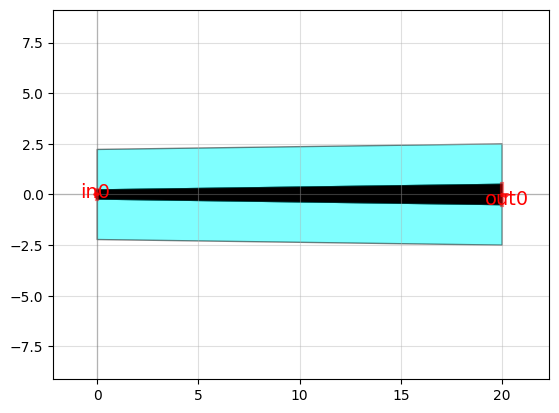

example_taper_length20: uid 7767780d, ports ['in0', 'out0'], references [], 4 polygons

In [3]:
taper = example_taper(width_input=0.45, width_output=1.0, length=20)
taper

In [4]:
from gdsfactory.tech import get_layer_stack_generic, LayerStack, LayerLevel
import numpy as np

nm = 1E-3

def get_layer_stack(
    t_slab: float = 0.020,
    t_soi: float = 0.220,
    t_ox: float = 1.0,
) -> LayerStack:
    """Returns meow."""
    return LayerStack(
        layers=dict(
            core=LayerLevel(
                layer=(1, 0),
                thickness=t_soi,
                zmin=0.0,
                material="si", # mw.silicon
                info={"mesh_order": 1},
            ),
            slab=LayerLevel(
                layer=(2, 0),
                zmin=0.0,
                material="si",
                thickness=t_slab,
                info={"mesh_order": 2},
            ),
            ),
        )

In [5]:
from gdsfactory.simulation.gmsh import uz_xsection_mesh

resolutions = {}
resolutions["core"] = {"resolution": 0.02, "distance": 2}
resolutions["slab"] = {"resolution": 0.05, "distance": 2}
resolutions["Oxide"] = {"resolution": 0.3, "distance": 2}

ymin = -2.5 # make sure all objects cross the line
ymax = 2.5 # make sure all objects cross the line
x = 0
xsection_bounds = [[x, ymin],[x, ymax]]

uz_xsection_mesh(
        taper,
        xsection_bounds,
        get_layer_stack(),
        resolutions=resolutions,
        background_tag="clad",
        background_padding=(1, 1, 1, 1), # how much of backgorund tag to add to each side of the simulatoin
        filename=f"mesh_x.msh",
    )

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : [ 90%] Meshing curve 15 (Line)
Info    : [100%] Meshing curve 16 (Line)
Info    : Done meshing 1D (Wall 0.0285471s, CPU 0.122065s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 80%] Meshing surface 4 (Plane, Frontal-Delaunay)
In

/usr/local/google/home/bilodeaus/Github/gdsfactory5_uz/gdsfactory/gdsfactory/simulation/gmsh/mesh.py:149: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in polygons if hasattr(polygons, "geoms") else [polygons]:


<meshio mesh object>
  Number of points: 1967
  Number of cells:
    line: 299
    triangle: 3871
    vertex: 14
  Cell sets: core___slab, core___clad, slab___clad, core, slab, clad

In [6]:
ymin = -2.5 # make sure all objects cross the line
ymax = 2.5 # make sure all objects cross the line
x = 20
xsection_bounds = [[x, ymin],[x, ymax]]

uz_xsection_mesh(
        taper,
        xsection_bounds,
        get_layer_stack(),
        resolutions=resolutions,
        background_tag="clad",
        background_padding=(1, 1, 1, 1), # how much of backgorund tag to add to each side of the simulatoin
        filename=f"mesh_x20.msh",
    )

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : [ 90%] Meshing curve 15 (Line)
Info    : [100%] Meshing curve 16 (Line)
Info    : Done meshing 1D (Wall 0.0330041s, CPU 0.032871s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 80%] Meshing surface 4 (Plane, Frontal-Delaunay)
In

<meshio mesh object>
  Number of points: 2593
  Number of cells:
    line: 357
    triangle: 5119
    vertex: 14
  Cell sets: core___slab, core___clad, slab___clad, core, slab, clad

In [7]:
import pyvista as pv

mesh = pv.read("mesh_x.msh")
cpos = mesh.plot(cpos="xy", show_edges=True, color=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [8]:
mesh = pv.read("mesh_x20.msh")
cpos = mesh.plot(cpos="xy", show_edges=True, color=True)# cmap='binary')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg

from skfem import BilinearForm, Basis, ElementTriN2, ElementDG, ElementTriP0, ElementTriP1, ElementTriP2, ElementVector, \
    Mesh, Functional, LinearForm
from skfem.helpers import curl, grad, dot, inner, cross

from femwell.mode_solver import compute_modes, plot_mode

mesh = Mesh.load('mesh_x.msh')
basis = Basis(mesh, ElementTriN2() * ElementTriP2())
basis0 = basis.with_element(ElementTriP0())
epsilon = basis0.zeros(dtype=complex)

indices_dict = {
                    'core': 3.4777,
                    'slab': 3.4777,
                    'clad': 1.444
                }

for name, refractive_index in indices_dict.items():
    epsilon[basis0.get_dofs(elements=name)] = refractive_index ** 2


lams, basis, xs = compute_modes(basis0, epsilon, wavelength=1.55, mu_r=1, num_modes=6)

UFuncTypeError: Cannot cast ufunc 'divide' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

[2.40200329-1.79718945e-08j 1.76352733+4.02347980e-08j
 1.54217036+3.46250310e-08j 1.47986079+1.30793318e-07j
 1.46081022-1.17552740e-08j 1.41766293-1.07983177e-07j]


[19:14:02] INFO     Initializing CellBasis(MeshTri1, ElementTriN2)                                 ]8;id=705311;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=633415;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#75\75]8;;\

           INFO     Initializing finished.                                                        ]8;id=694985;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=19642;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#100\100]8;;\

           INFO     Initializing CellBasis(MeshTri1, ElementTriP2)                                 ]8;id=631787;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=310938;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#75\75]8;;\

           INFO     Initializing finished.                                                        ]8;id=698441;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=286752;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#100\100]8;;\

           INFO     Initializing CellBasis(MeshTri1, ElementVector)                                ]8;id=678882;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=472540;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#75\75]8;;\

           INFO     Initializing finished.                                                        ]8;id=340187;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=833843;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#100\100]8;;\

           INFO     Assembling '<lambda>'.                                                     ]8;id=471189;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/form/bilinear_form.py\bilinear_form.py]8;;\:]8;id=780856;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/form/bilinear_form.py#145\145]8;;\

           INFO     Assembling finished.                                                       ]8;id=354416;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/form/bilinear_form.py\bilinear_form.py]8;;\:]8;id=788885;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/form/bilinear_form.py#147\147]8;;\

           INFO     Assembling '<lambda>'.                                                               ]8;id=697838;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/form/form.py\form.py]8;;\:]8;id=619669;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/form/form.py#75\75]8;;\

           INFO     Assembling finished.                                                                 ]8;id=435926;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/form/form.py\form.py]8;;\:]8;id=745816;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/form/form.py#78\78]8;;\

           INFO     Solving linear system, shape=(23226, 23226).                                       ]8;id=912064;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/utils.py\utils.py]8;;\:]8;id=413250;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/utils.py#260\260]8;;\

           INFO     Solving done.                                                                      ]8;id=930685;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/utils.py\utils.py]8;;\:]8;id=976188;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/utils.py#267\267]8;;\

           INFO     Initializing CellBasis(MeshTri1, ElementDG)                                    ]8;id=927715;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=862479;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#75\75]8;;\

           INFO     Initializing finished.                                                        ]8;id=119529;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=747814;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#100\100]8;;\

           INFO     Initializing CellBasis(MeshTri1, ElementDG)                                    ]8;id=265428;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=295821;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#75\75]8;;\

           INFO     Initializing finished.                                                        ]8;id=191148;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py\cell_basis.py]8;;\:]8;id=101833;file:///usr/local/google/home/bilodeaus/Github/scikit-fem/skfem/assembly/basis/cell_basis.py#100\100]8;;\

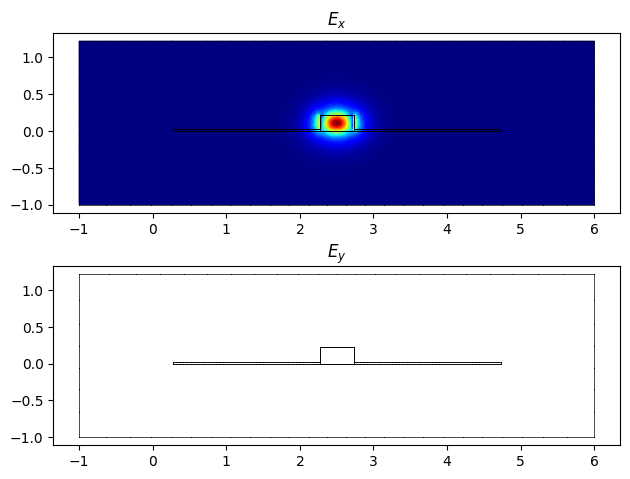

In [ ]:
print(lams)

plot_mode(basis, np.real(xs[0]), title='E', direction='y', field_components='xy', colorbar=False)
plt.show()

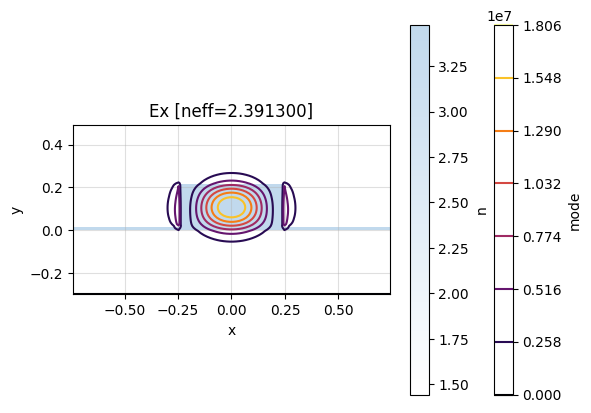

In [ ]:
num_modes=4
modes = mw.compute_modes(css[0], num_modes=num_modes)
mw.visualize(modes[0])

In [ ]:
%%time
num_modes = 4
modes = [mw.compute_modes(cs, num_modes=num_modes) for cs in css]

CPU times: user 3min 28s, sys: 12.1 s, total: 3min 40s
Wall time: 5.47 s


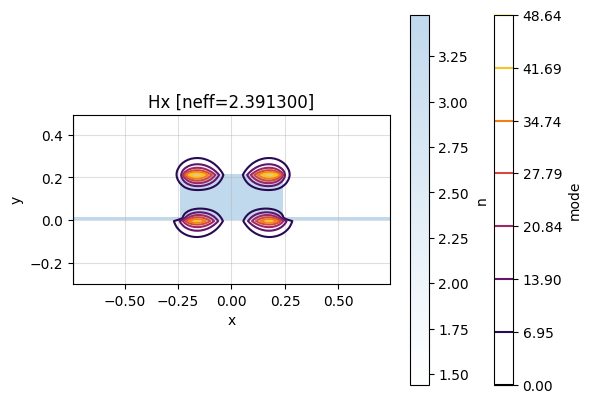

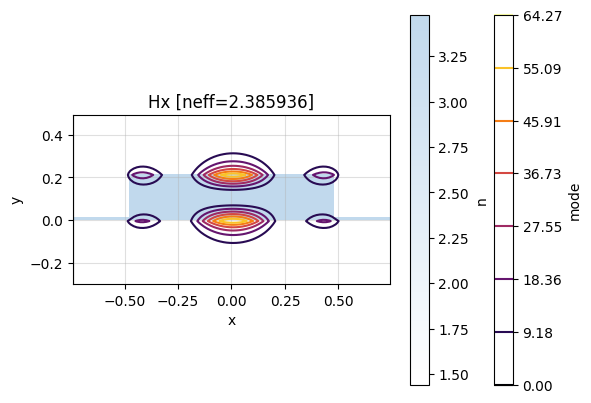

In [ ]:
mw.visualize(modes[0][0], fields=["Hx"])
mw.visualize(modes[-1][1], fields=["Hx"])

{'left@0': 0, 'left@1': 1, 'left@2': 2, 'left@3': 3, 'right@0': 4, 'right@1': 5, 'right@2': 6, 'right@3': 7}


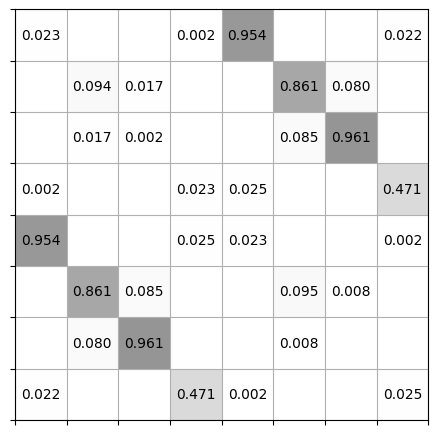

In [ ]:
S, port_map = mw.compute_s_matrix(modes)
print(port_map)
mw.visualize(S)